### Predictive Analytics

In [10]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [11]:
%watermark -a 'Durga' -v -d -p numpy,pandas,matplotlib,sklearn,keras,seaborn

Durga 2017-01-01 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
sklearn 0.18.1
keras 1.2.0
seaborn 0.7.1


In [12]:
# CSS Fileb
from IPython.core.display import HTML
from IPython.display import Image

In [13]:
%matplotlib inline

# general libs
import sys
import numpy as np
import pandas as pd
import sklearn

#plotting libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter

# date time libs
import datetime as dt
from datetime import timedelta
import statsmodels.api as sm 

# ml libs
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")


In [14]:
# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css));

In [15]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

### Overview

Say you are an admin with 100+ volumes and want to know approximately when a given volume capacity will be full? Or approximately what would be the available capacity of the given volume in 4 weeks? Or you might want this information at environment level i.e., say how many volumes are at risk of filling up in next 4 weeks and how much is the risk etc. Or may be your interest is not necessarily capacity availability but some other resource availability.

There could be many reasons for needing this info. Ex: To plan & proactively do the necessary procurements, rebalancing etc.  

This notebook utilizes Deep Learning (LSTM RNN Neural network) & Montecarlo Simulation techniques to do the above. Some key challenges here are (a) different volumes have different usage behaviors and (b) different volumes have different trend & seasonalities in their data. 

### APIs...

In [16]:
##### DATA API ###########

def read_metric_data(csv_name):
    '''
        Read data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
    print("{0} --- #(rows:columns): {1}".format(csv_name, df.shape))
    return df

def rename_series(series, prefix='v'):
    s = series.unique()
    newS = pd.Series(np.arange(len(s), dtype=np.int))
    newS = newS.apply(lambda x:  prefix + str(x))
    d = dict(zip(s, newS))
    newSeries =series.map(d)
    return newSeries

def expand_df(df, ef=2, freq='D'):
    d = df.copy()
    d1 = pd.concat([df]*ef, ignore_index=True)
    d1.index = pd.date_range(df.index[0], periods=len(d1), freq=freq)
    return d1

In [17]:
##### MODEL API ###########

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def model_rnn_lstm(dataframe, seed=9, title='title'):
    # fix random seed for reproducibility
    np.random.seed(seed)

    # load the dataset
    df = dataframe
    dataset = df.values
    dataset = dataset.astype('float32')

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    look_back = 2
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    #trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    #testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(12, input_dim=look_back))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=0)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('%s:, Train_Score: %.2f RMSE, Test_Score: %.2f RMSE' % (title, trainScore, testScore))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # Plot base lines & predictions
    fig = plt.figure(figsize=(12, 3))
    ax = plt.gca()
    plt.plot(scaler.inverse_transform(dataset), color='steelblue', linewidth=3, label='Original', alpha=0.7)
    plt.plot(trainPredictPlot, color='sage', label='TrainPredict')
    plt.plot(testPredictPlot, color='indianred', label='TestPredict')
    plt.xlabel("x", fontweight='bold')
    plt.ylabel("GB", fontweight='bold')
    plt.title(title + ": " + "Baseline & Predictions")
    plt.legend(loc='best')


In [18]:
##### Montecarlo API ###########

def get_days_forecast(df, freecapacity):
    daysleft = 0
    availcap = freecapacity
    while availcap >= 0:
        usage = np.random.choice(df, 1, replace=True)
        availcap = availcap - usage
        daysleft = daysleft + 1
    return daysleft

def montecarlo_days_forecast(df, freecapacity, iterations=10000):    
    # Init
    lastday = df.index[-1]
    days_s = pd.Series(np.zeros(iterations, dtype=int), name='days_s')
    dates_s = pd.Series(np.zeros(iterations), name='dates_s')
    
    #Forecast days & dates
    for i in range(iterations):
        days_s[i] = get_days_forecast(df, freecapacity)
        dates_s[i] = lastday + timedelta(days_s[i])
    days_s = days_s.dropna()
    dates_s = dates_s.sort_values()
    return (days_s, dates_s)


def get_usage_forecast(df, days=100):
    s = pd.Series(np.zeros(days, dtype=float), name='capacity_usage')
    s[0] = 0
    for i in range(1, days+1):
        usage = np.random.choice(df, 1, replace=True)
        s[i] = s[i-1]+usage
    #pd.to_numeric(s, errors='coerce')
    return s

def montecarlo_usage_forecast(df, days=100, iterations=10000):
    lastday = df.index[-1]
    cap_index = pd.date_range(lastday, periods=days+1, freq='D')
    cap_usage_df = pd.DataFrame(index=cap_index)
    
    for i in range(iterations):
        series  = get_usage_forecast(df, days)
        series.index = cap_index
        cap_usage_df.loc[:, i] = series
        
    cap_usage_df = cap_usage_df.dropna()
    return cap_usage_df

In [19]:
##### PLOTTING API ###########


def create_trend_plot(xlabel, ylabel, title, df):
    # Create line chart
    fig = plt.figure(figsize=(14, 4))
    ax = plt.gca()
    ax.xaxis.set_major_locator(DayLocator(interval=7))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d')) # TimeFormat : http://strftime.org/
    plt.plot(df.total, color='gray', linewidth=3, linestyle= '--', label='Total Capacity')
    plt.plot(df.used, color='steelblue', label='Capacity Used')
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.title(title)
    plt.legend(loc='best')
    plt.gcf().autofmt_xdate()
    return

def create_shape_plots(xlabel, ylabel, title, df):
    #Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    
    # Box-Whiskers Plot
    x = df.pivot(columns='week_days', values='diff')
    x = x.rename(columns={0: 'Mon', 1: 'Tue', 2:'Wed', 3:'Thur', 4:'Fri', 5:'Sat', 6:'Sun'})
    g1 = sns.violinplot(data=x, palette=sns.color_palette(), split=True, ax=axes[0])
    g1.set_xlabel(xlabel, fontweight='bold', fontsize=12)
    g1.set_ylabel(ylabel, fontweight='bold', fontsize=12)
    g1.set_title(title)

    # Swarm Plot
    g2 = sns.stripplot(data=df['diff'], jitter=True, size=4, color=".1", linewidth=0, ax=axes[1])
    g3 = sns.violinplot(data=df['diff'], palette=sns.color_palette(), split=True, ax=axes[1])
    g3.set_xlabel('')
    g3.set_ylabel(ylabel, fontweight='bold', fontsize=12)
    g3.set_title(title)
    return

def create_ecdf_plots(ylabel, title, cap_full_days, cap_full_dates):
    #Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    
    ecdf1 = sm.distributions.ECDF(cap_full_days)
    x1 = np.linspace(min(cap_full_days), max(cap_full_days))
    y1 = ecdf1(x1)
    
    ecdf2 = sm.distributions.ECDF(cap_full_dates)
    x2 = cap_full_dates
    y2 = ecdf2(x2)
    
    axes[0].step(x1, y1)
    axes[0].set_title(title)
    axes[0].set_xlabel("Days", fontweight='bold')
    axes[0].set_ylabel(ylabel, fontweight='bold')
    
    axes[1].step(x2, y2)
    axes[1].set_title(title)
    axes[1].set_xlabel("Date", fontweight='bold')
    axes[1].set_ylabel(ylabel, fontweight='bold')
    plt.gcf().autofmt_xdate()
    return

def create_forecast_plot(xlabel, ylabel, title, df):
    # Create line chart
    fig = plt.figure(figsize=(14, 4))
    ax = plt.gca()
    #ax.xaxis.set_major_locator(DayLocator(interval=7))
    #ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d')) # TimeFormat : http://strftime.org/
    plt.plot(df, color='slategray', label='Capacity Used', alpha=0.7)
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.title(title)
    plt.gcf().autofmt_xdate()
    return

### Data Load & Cleanup...

In [20]:
# Read capacity used metric
df_used1 = read_metric_data("data/capacity/kelsey-capused-d.txt")
df_used2 = read_metric_data("data\capacity\dogfood-v1-capused-d.txt")
df_total = read_metric_data("data\capacity\dogfood-v1-captotal-d.txt")

# revise server values
df_used1.server = rename_series(df_used1.server, prefix="v")
df_used2.server = rename_series(df_used2.server, prefix="v")
df_total.server = rename_series(df_total.server, prefix="v")

# Preprocess Data
df_used1.loc[:,('value')] = (df_used1.value/(1024*1024*1024)).round(2)
df_used2.loc[:,('value')] = (df_used2.value/(1024*1024*1024)).round(2)
df_total.loc[:,('value')] = (df_total.value/(1024*1024*1024)).round(2)

# group data by server
g1 = df_used1.groupby('server')
g2 = df_used2.groupby('server')

#df.loc[:,'diff'] = df.value.diff()

data/capacity/kelsey-capused-d.txt --- #(rows:columns): (4156, 2)
data\capacity\dogfood-v1-capused-d.txt --- #(rows:columns): (92, 2)
data\capacity\dogfood-v1-captotal-d.txt --- #(rows:columns): (92, 2)


#### Summary statistics....

In [21]:
print("Summary stats across all servers...")
summary = g1.describe().T
#summary = summary.drop("count", axis=0)
summary = summary.round(2)
summary

Summary stats across all servers...


C:\Users\durga\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


server    v0                                                  v1         \
       count   mean    std   min    25%   50%   75%    max count   mean   
value   42.0  38.81  16.04  3.59  36.46  43.0  49.7  65.14  42.0  40.38   

server  ...   v97         v98                                                 
        ...   75%   max count   mean   std    min    25%   50%    75%    max  
value   ...   NaN  7.91  40.0  18.56  1.19  16.85  17.47  18.2  19.57  20.88  

[1 rows x 792 columns]

### Modelling (LSTM RNN) & Evaluation

Type1: Cyclical Behavior
Volume-0:, Train_Score: 7.64 RMSE, Test_Score: 6.84 RMSE


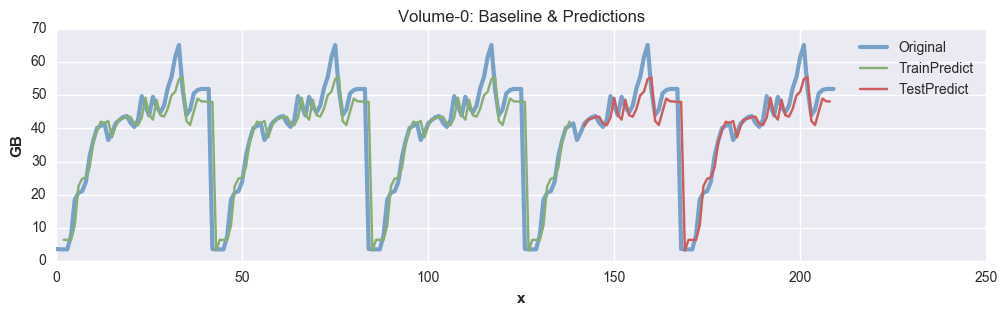

In [22]:
# expand data
print("Type1: Cyclical Behavior")
vdf0 = expand_df(g1.get_group("v0"), ef=5, freq='D')
model_rnn_lstm(vdf0[['value']], seed=7, title="Volume-0")

Type2: Run Up & Flat Behavior
Volume-2:, Train_Score: 46.02 RMSE, Test_Score: 19.88 RMSE


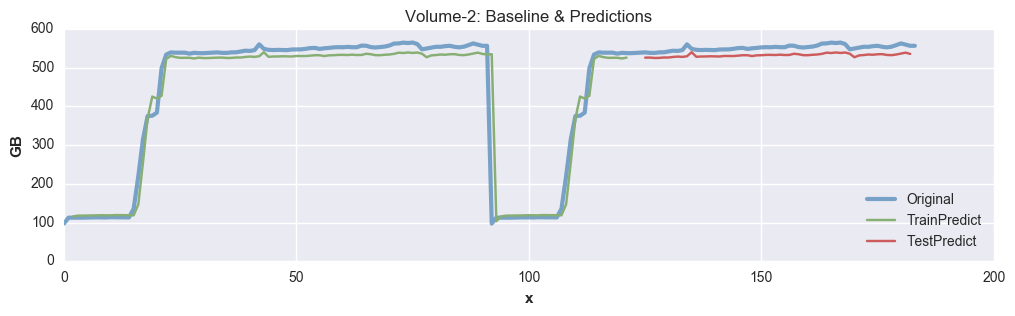

In [23]:
print("Type2: Run Up & Flat Behavior")
vdf2 = expand_df(g2.get_group("v0"), ef=2, freq='D')
model_rnn_lstm(vdf2[['value']], seed=7, title="Volume-2")

Type3: Mixed (sideways & trend) Behavior
Volume-8:, Train_Score: 1.15 RMSE, Test_Score: 1.08 RMSE


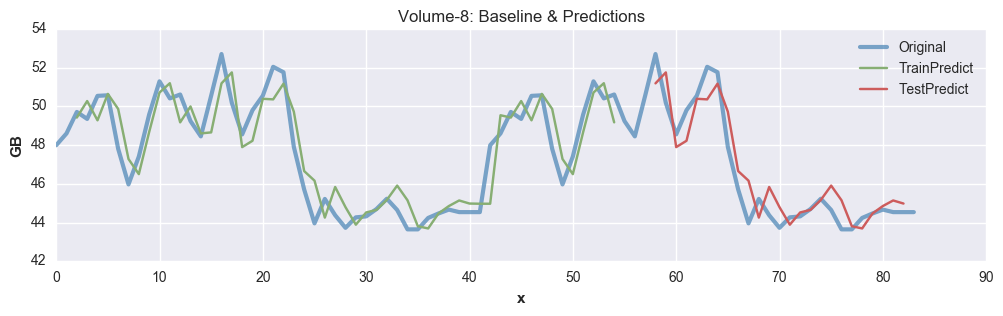

In [24]:
print("Type3: Mixed (sideways & trend) Behavior")
vdf8 = expand_df(g1.get_group("v8"), ef=2, freq='D')
model_rnn_lstm(vdf8[['value']], seed=7, title="Volume-8")

### Montecarlo Simulations & Analytics...

In [25]:
df_used = df_used2.copy()
df_total = df_total.copy()

df_trend = pd.DataFrame(index=df_used.index)
df_trend['total'] = df_total.value.round(2)
df_trend['used'] = df_used.value.round(2)

df_diff = pd.DataFrame(index= df_used.index)
df_diff['diff'] = df_used.value.diff()
df_diff = df_diff.dropna()
df_diff['week_days'] = df_diff.index.weekday

In [26]:
days = 100
simulations = 1000

totalcap = df_total.value.iloc[1]
usedcap = df_used.value.iloc[-1]
freecapacity = totalcap - usedcap

cap_full_days, cap_full_dates = montecarlo_days_forecast(df_diff['diff'], freecapacity, simulations)
cap_usage_df = montecarlo_usage_forecast(df_diff['diff'], days, simulations)

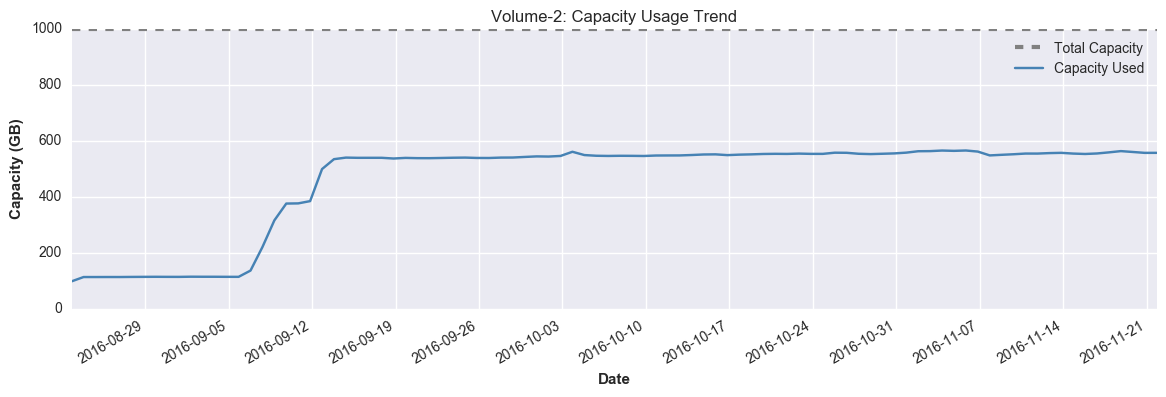

In [27]:
create_trend_plot("Date", "Capacity (GB)", "Volume-2: Capacity Usage Trend", df_trend)

* Notice the width and height of bars in patterns. width = how often. height = how far.


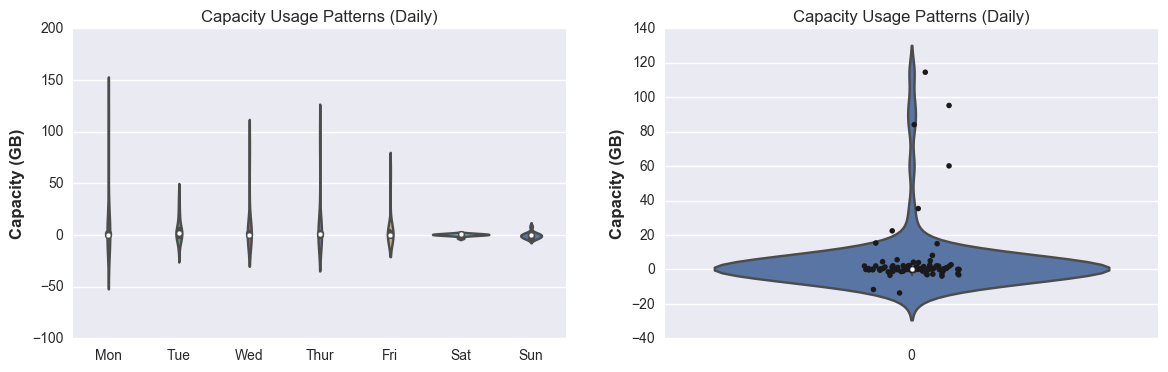

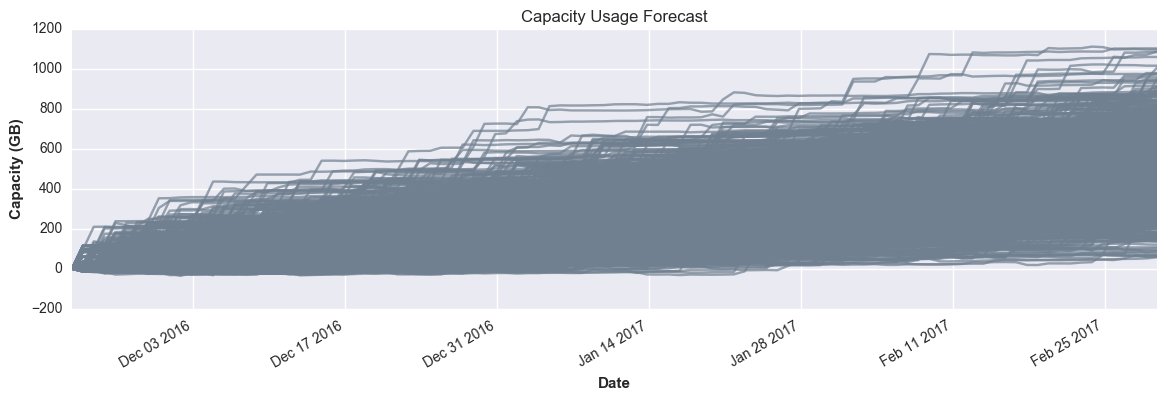

In [28]:
print("* Notice the width and height of bars in patterns. width = how often. height = how far.")
create_shape_plots("","Capacity (GB)", "Capacity Usage Patterns (Daily)", df_diff)
create_forecast_plot("Date", "Capacity (GB)", "Capacity Usage Forecast", cap_usage_df)

* Generally 0.8 probability is a good target for full capacity...


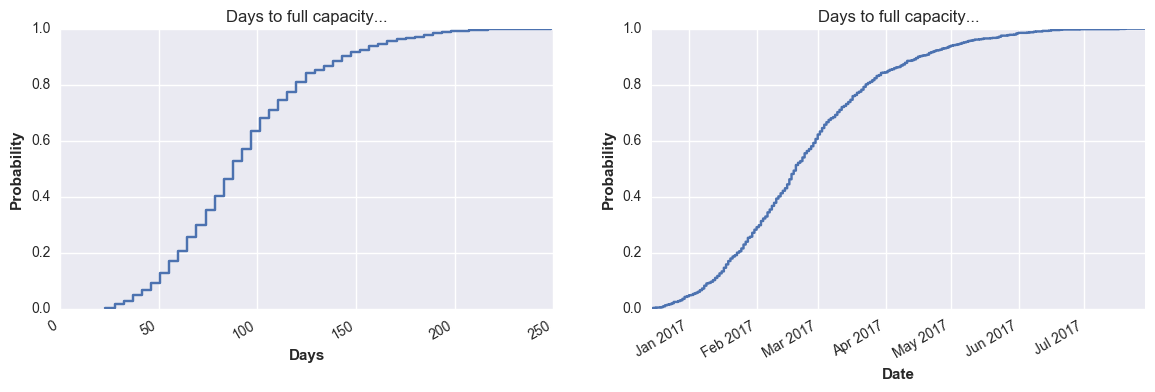

In [29]:
create_ecdf_plots("Probability","Days to full capacity...", cap_full_days, cap_full_dates)
print("* Generally 0.8 probability is a good target for full capacity...")